# KNN - CLASSIFICATION

In [435]:
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [436]:
train_df = pd.read_csv("pp_train.csv")
test_df = pd.read_csv("pp_test.csv")

copy_train = train_df.copy()
copy_test = test_df.copy()

### Preprocessing delle variabili

##### Eliminazione variabili inutilizzabili

In [437]:
copy_train.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller',
       'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography',
       'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult',
       'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short',
       'is_Fantasy', 'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama',
       'is_Sport', 'is_War', 'is_Horror', 'is_Animation',
       'fill_runtimeMinutes', 'is_from_Oceania', 'is_from_North America',
       'is_from_South America', 'is_from_Asia', 'is_from_Africa',
       'is_from_Europe'],
      dtype='object')

In [438]:
copy_test.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'isAdult', 'numRegions', 'userReviewsTotal',
       'is_Western', 'is_Thriller', 'is_Horror', 'is_Animation', 'is_Family',
       'is_News', 'is_Sport', 'is_Reality-TV', 'is_Biography', 'is_Sci-Fi',
       'is_Fantasy', 'is_Documentary', 'is_Talk-Show', 'is_Drama', 'is_Music',
       'is_Game-Show', 'is_Adventure', 'is_Romance', 'is_Mystery', 'is_Short',
       'is_Action', 'is_Adult', 'is_History', 'is_Musical', 'is_Crime',
       'is_Film-Noir', 'is_War', 'is_Comedy', 'fill_runtimeMinutes',
       'is_from_South America', 'is_from_Oceania', 'is_from_Europe',
       'is_from_Asia', 'is_from_Africa', 'is_from_North America'],
      dtype='object')

##### Mapping variabile target

In [439]:
y = np.array(copy_train['titleType'])  # Il target originale

# Creiamo un dizionario che associa ogni categoria a un numero
y_map = {title: idx for idx, title in enumerate(copy_train['titleType'].unique())}

#aggiungo una nuova colonna
copy_train['titleType_encoded'] = copy_train['titleType'].map(y_map)
copy_test['titleType_encoded'] = copy_test['titleType'].map(y_map)

y_map  # Per vedere la mappatura delle categorie

{'tvEpisode': 0,
 'videoGame': 1,
 'movie': 2,
 'tvSeries': 3,
 'video': 4,
 'tvMiniSeries': 5,
 'short': 6,
 'tvMovie': 7,
 'tvSpecial': 8,
 'tvShort': 9}

#### Conversione CanHaveEpisodes in binaria 0/1

In [440]:
copy_train["canHaveEpisodes"] = copy_train["canHaveEpisodes"].astype(int)
copy_test["canHaveEpisodes"] = copy_test["canHaveEpisodes"].astype(int)

#### Rimuoviamo titleType dato che è già stata mappata + originaltitle e runtimeminutes non filled

In [441]:
copy_train = copy_train.drop(["originalTitle", "runtimeMinutes"], axis=1)
copy_test = copy_test.drop(["originalTitle", "runtimeMinutes"], axis=1)

In [442]:
copy_train = copy_train.drop(["titleType"], axis=1)
copy_test = copy_test.drop(["titleType"], axis=1)

#### Rimuoviamo endYear (fino a quando non capiamo come sostituirlo)

In [443]:
copy_train = copy_train.drop(["endYear"], axis=1)
copy_test = copy_test.drop(["endYear"], axis=1)

#### Encoding di titletype per multiclass classification task

In [444]:
# Extract target (y)
y_train = copy_train["titleType_encoded"].values  # Convert directly to NumPy
y_test = copy_test["titleType_encoded"].values  # Convert directly to NumPy

#### Selezione variabili

In [445]:
selected_var_tr = copy_train[['startYear', 'awardWins', 'numVotes', 'totalImages',
       'totalCredits', "totalVideos", 'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
       'numRegions', 'userReviewsTotal', 
       "fill_runtimeMinutes", 
       "rating", 'is_from_Oceania', 'is_from_Europe',
       'is_from_Asia', 'is_from_Africa', 'is_from_North America']].values

selected_var_ts = copy_test[['startYear', 'awardWins', 'numVotes', 'totalImages',
       'totalCredits', "totalVideos", 'criticReviewsTotal', 'canHaveEpisodes', 'isAdult',
       'numRegions', 'userReviewsTotal',
       "fill_runtimeMinutes", 
       "rating", 'is_from_Oceania', 'is_from_Europe',
       'is_from_Asia', 'is_from_Africa', 'is_from_North America']].values

#### Splitting train-validation

In [446]:
X_train2, X_val, y_train2, y_val = train_test_split(
     selected_var_tr, y_train, test_size=0.2, random_state=32
)

# X_train2 = training set --> 80% di X_train
# X_val = validation set --> 20% di X_train
# y_train2 e y_val sono i target corrispondenti (etichette) per i dati di addestramento e validazione

In [447]:
print(X_train2.shape, X_val.shape, selected_var_ts.shape)

(13144, 18) (3287, 18) (5478, 18)


#### Normalizzazione

In [448]:
X_train2_numeric_log = np.log1p(X_train2)
X_val_numeric_log = np.log1p(X_val)

X_test_numeric_log = np.log1p(selected_var_ts)

In [449]:
scaler = StandardScaler()

# # Fittiamo SOLO su train e trasformiamo tutto
X_train2_standardsc = scaler.fit_transform(X_train2_numeric_log)
X_val_standardsc = scaler.fit_transform(X_val_numeric_log)

X_test_standardsc = scaler.transform(X_test_numeric_log)


In [450]:
minmax = MinMaxScaler()

# # Fitta e trasforma il training set in un solo passaggio
X_train2_minmax = minmax.fit_transform(X_train2_numeric_log)
X_val_minmax = minmax.fit_transform(X_val_numeric_log)

X_test_minmax = minmax.transform(X_test_numeric_log)

## KNN

### RandomizedSearch per trovare gli iperparametri

### FUNZIONE VECCHIA

In [451]:
# import numpy as np
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
# from scipy.stats import randint

# def optimize_knn(X_train, y_train, n_iter=100, cv=5, verbose=1):
#     # Calculate reasonable k range based on square root rule
#     # sqrt(N) is a common rule of thumb for KNN
#     sqrt_n = int(np.sqrt(X_train.shape[0]))
    
#     # Define parameter space with more focused ranges
#     param_distributions = {
#         "n_neighbors": np.arange(1, sqrt_n+1),  # Focus around sqrt(N)
#         "weights": ["uniform", "distance"],
#         "metric": ["euclidean", "cityblock"]
#     }
    
#     # Create the RandomizedSearchCV object with improved settings
#     random_search = RandomizedSearchCV(
#         KNeighborsClassifier(),
#         param_distributions=param_distributions,
#         n_iter=n_iter,
#         cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),  # Stratified k-fold is usually sufficient
#         n_jobs=-1,
#         refit=True,
#         random_state=42,
#         verbose=verbose,
#         scoring='accuracy',  # Specify your preferred metric
#         return_train_score=True  # Good for checking overfitting
#     )
    
#     # Fit the model
#     random_search.fit(X_train2_standardsc, y_train)
    
#         # Show top 5 models to see parameter sensitivity
#     results = random_search.cv_results_
#     sorted_idx = np.argsort(results['rank_test_score'])
#     print("\nTop 5 configurations:")
#     for i in range(5):
#         idx = sorted_idx[i]
#         print(f"Rank {i+1}: {results['params'][idx]}")
#         print(f"   Test score: {results['mean_test_score'][idx]:.4f}")
#         print(f"   Train score: {results['mean_train_score'][idx]:.4f}")

#     return random_search.best_estimator_, random_search.best_params_, random_search.best_score_

### FUNZIONE NUOVA

In [452]:
# import numpy as np
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
# from sklearn.metrics import accuracy_score

# def optimize_knn_with_external_validation(X_train, y_train, X_val, y_val, n_iter=100, cv=5, verbose=1):
#     # Calcolo range k
#     sqrt_n = int(np.sqrt(X_train.shape[0]))
    
#     param_distributions = {
#         "n_neighbors": np.arange(1, sqrt_n + 1),
#         "weights": ["uniform", "distance"],
#         "metric": ["euclidean", "cityblock"]
#     }
    
#     random_search = RandomizedSearchCV(
#         KNeighborsClassifier(),
#         param_distributions=param_distributions,
#         n_iter=n_iter,
#         cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
#         n_jobs=-1,
#         refit=True,
#         random_state=42,
#         verbose=verbose,
#         scoring='accuracy',
#         return_train_score=True
#     )

#     # Fit solo sul training set
#     random_search.fit(X_train, y_train)
# #
#     # Valutazione su validation set
#     best_model = random_search.best_estimator_
#     y_val_pred = best_model.predict(X_val)
#     val_accuracy = accuracy_score(y_val, y_val_pred)

#     # Mostra le top 5 configurazioni (sulla cross-validation)
#     results = random_search.cv_results_
#     sorted_idx = np.argsort(results['rank_test_score'])
#     print("\nTop 5 configurations (CV scores):")
#     for i in range(5):
#         idx = sorted_idx[i]
#         print(f"Rank {i+1}: {results['params'][idx]}")
#         print(f"   CV Test score: {results['mean_test_score'][idx]:.4f}")
#         print(f"   CV Train score: {results['mean_train_score'][idx]:.4f}")

#     print(f"\nValidation Accuracy of Best Model: {val_accuracy:.4f}")

#     return best_model, random_search.best_params_, val_accuracy

### CELLA DA RUNNARE DOPO AVER CONTROLLATO NUOVA CONFIGURAZIONE PARAMETRI

In [453]:
# # best_knn, best_params, best_score = optimize_knn(X_train2_standardsc, y_train2)

# best_knn, best_params, val_score = optimize_knn_with_external_validation(
#     X_train2_standardsc, y_train2, X_val_standardsc, y_val)


# # # Create a new classifier with the optimized parameters
# clf = KNeighborsClassifier(**best_params)
# clf.fit(X_train2_standardsc, y_train2)

# y_pred = clf.predict(X_val_standardsc)

### CELLA DA RUNNARE SE SI SANNO GIA' I PARAMETRI

In [454]:
clf = KNeighborsClassifier(weights = 'distance', n_neighbors= 20, metric = 'cityblock')
clf.fit(X_train2_standardsc, y_train2)

y_pred = clf.predict(X_val_standardsc)

In [455]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

3287
3287


#### Predicting on validation set

In [456]:
print(set(y_val)) 
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8}


In [457]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.8436264070581077

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       936
           1       0.89      0.34      0.49        50
           2       0.87      0.93      0.90      1121
           3       0.89      1.00      0.94       268
           4       0.75      0.46      0.57       163
           5       1.00      0.11      0.20        37
           6       0.88      0.85      0.87       501
           7       0.64      0.28      0.39       173
           8       1.00      0.04      0.07        28
           9       0.00      0.00      0.00        10

    accuracy                           0.84      3287
   macro avg       0.77      0.50      0.53      3287
weighted avg       0.84      0.84      0.82      3287



C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Gagia\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### distribuzione classi nel training set; da notare come le classi con support più basso sono ovviamente quelle con performance peggiori
valutare se togliere class 1, 5, 8, 9 (come francesco) 

In [458]:
class_distribution = pd.Series(y_train2).value_counts().sort_index()

# Mostra i conteggi
print("Distribuzione delle classi nel training set:")
print(class_distribution)

Distribuzione delle classi nel training set:
0    3762
1     209
2    4414
3    1107
4     629
5     187
6    1973
7     695
8     138
9      30
Name: count, dtype: int64


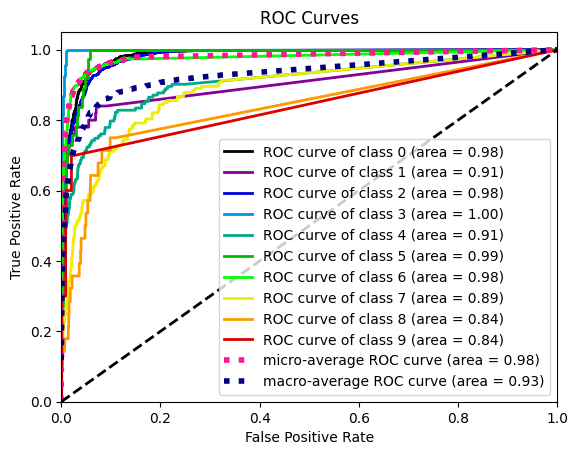

In [459]:
y_val_pred_proba = clf.predict_proba(X_val_standardsc)
plot_roc(y_val, y_val_pred_proba)
plt.show()

### confusion matrix non funziona perchè alcune classi non le ha predette (vedi class report)

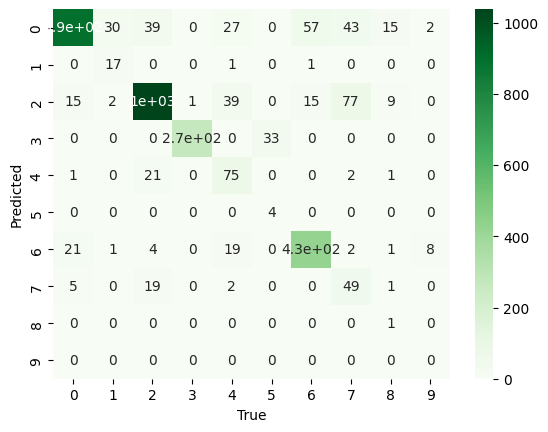

In [460]:
cf = confusion_matrix(y_pred, y_val)
sns.heatmap(cf, annot=True, cmap="Greens")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()